## Web Analytics DATA 620 - Week 02 - Part 01
## Assignment: “Graph Visualization”
## Group - Chris Bloome / Mustafa Telab / Vinayak Kamath
## Date - 11th June 2021

This week's assignment is to:
1. Load a graph database of your choosing from a text file or other source. If you take a
large network dataset from the web (such as from https://snap.stanford.edu/data/), please
feel free at this point to load just a small subset of the nodes and edges.
2. Create basic analysis on the graph, including the graph’s diameter, and at least one other
metric of your choosing. You may either code the functions by hand (to build your
intuition and insight), or use functions in an existing package.
3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.
4. Please record a short video (~ 5 minutes), and submit a link to the video as part of your
homework submission.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import neo4j as neo
from sklearn import preprocessing
import numpy as np
import math
import re

In [2]:
import os
os.chdir('/Users/mustafatelab/Desktop/CUNY SPS MSDS/DATA 620 Web Analytics/SPS_MSDS_SMR21_DATA620')

For this exercise we are pulling product amazon.com product review data from 
https://snap.stanford.edu/data/web-Amazon.html

In [3]:
#Parsing instructions provided @https://snap.stanford.edu/data/web-Amazon.html
import gzip
import simplejson

def parse(filename):
  f = gzip.open(filename, 'rt', encoding = 'latin 1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

After parsing the raw data, we move to transform it into a pandas dataframe

In [4]:
raw = []
for e in parse('Data/finefoods.txt.gz'):
  raw.append(e)

In [5]:
df = pd.DataFrame(raw)

In [6]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Now we can convert to a graph object.

In [72]:
G = nx.convert_matrix.from_pandas_dataframe(df, source='review/userId', target='product/productId',edge_attr= 'review/score' ,create_using = nx.DiGraph())

In [8]:
list(nx.degree_centrality(G).values())[1:10]

[3.0273948964176835e-06,
 3.0273948964176835e-06,
 3.0273948964176835e-06,
 9.082184689253051e-06,
 3.0273948964176835e-06,
 9.082184689253051e-06,
 3.0273948964176835e-06,
 6.054789792835367e-06,
 1.2109579585670734e-05]

In [9]:
nx.diameter(G.to_undirected())

NetworkXError: Graph not connected: infinite path length

From running the diameter function above, we learn that the graph is not completely connected.  We can evaluate this futher by looking at the connected components.

In [10]:
components = list(nx.connected_components(G.to_undirected()))
comp_count = len(components)
print('The total number of seperated subgraphs or components is',comp_count)

The total number of seperated subgraphs or components is 22079


In [11]:
comp_lens = pd.DataFrame([len(c) for c in components], columns = ['size'])
print('The median size of these components is', comp_lens.median()[0])
print('The average size of these components is', comp_lens.mean()[0])

The median size of these components is 2.0
The average size of these components is 14.960731917206395


In [12]:
comp_lens[comp_lens['size']>20].sort_values('size', ascending=False).head()

,size
2,269996
785,135
3681,46
1565,39
9233,34


In [13]:
print('The largest component encompasses most of the graph with size of', comp_lens[comp_lens['size']>20].sort_values('size', ascending=False).iloc[0]['size'])

The largest component encompasses most of the graph with size of 269996


Lets glance at the total Graph...

In [14]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 330318
Number of edges: 560805
Average in degree:   1.6978
Average out degree:   1.6978


The conclusion from the components analysis is that the graph is indeed fairly well connected by a large percentage, but there is a dusting of small private reviewer-product relationships.

For the rest of the analysis, we will pluck of one of the medium sized subgraphs.

In [15]:
S = G.subgraph(components[785])

In [16]:
print(nx.info(S))

Name: 
Type: DiGraph
Number of nodes: 135
Number of edges: 136
Average in degree:   1.0074
Average out degree:   1.0074


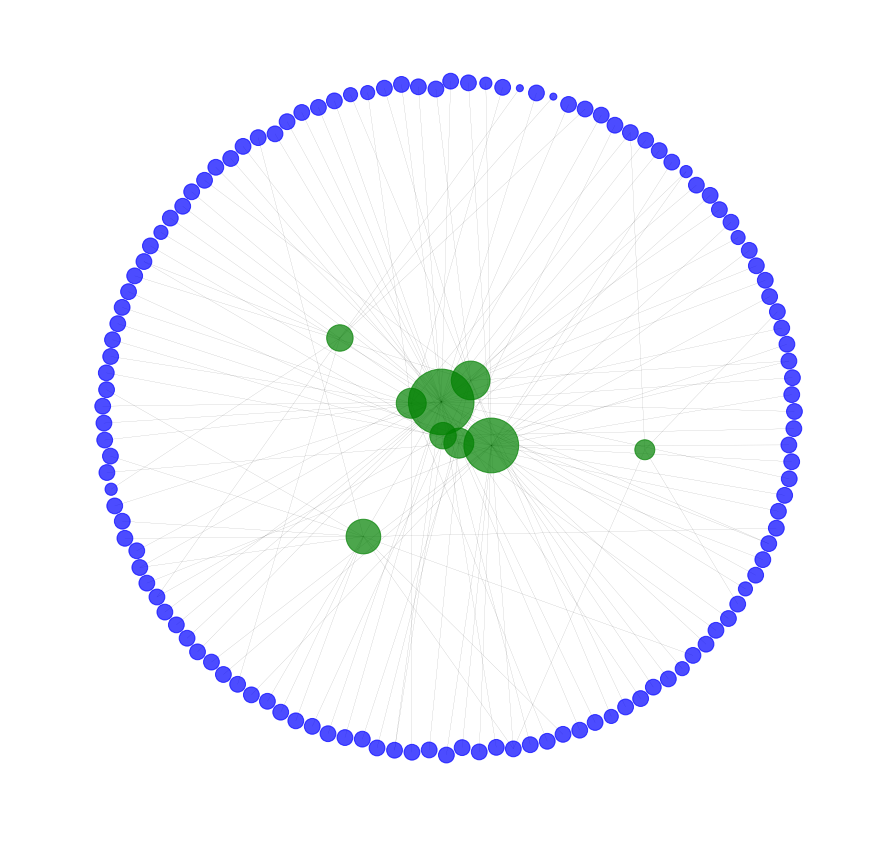

In [181]:
#Blue are the people, Green are the products
#Products are sized in proportion to their degree, people are sized per their average rating
S_col = ['blue' if n[0] == 'A' else 'green' for n in S.nodes()]
S_size = [sum(np.array([float(S[n][v]['review/score']) for n,v in S.edges(n)]))*50/np.array(S.degree(n)) if n[0] == 'A' else np.array(S.degree(n))*100 for n in S.degree()]
S_weights = np.array([float(S[u][v]['review/score']) for u,v in S.edges()])
S_weights_sd = math.sqrt(sum((S_weights - S_weights.mean())**2)/len(S_weights))
S_weights_norm = ((S_weights - S_weights.mean())/S_weights_sd)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(S,node_color=S_col,alpha = .7,width = .1, arrows=False , node_size = S_size)
plt.show()

## Metrics
Now lets pull some basic centrality measures.

##### Diameter

In [18]:
nx.diameter(S.to_undirected())

16

##### Degree

(array([125.,   1.,   1.,   0.,   2.,   2.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ,
        16.4, 17.8, 19.2, 20.6, 22. , 23.4, 24.8, 26.2, 27.6, 29. , 30.4,
        31.8, 33.2, 34.6, 36. , 37.4, 38.8, 40.2, 41.6, 43. ]),
 <a list of 30 Patch objects>)

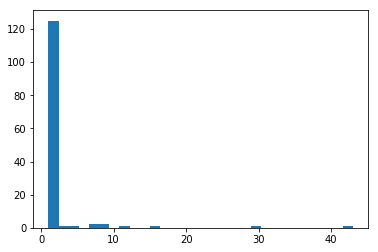

In [19]:
plt.hist(S.degree().values(), bins = 30)

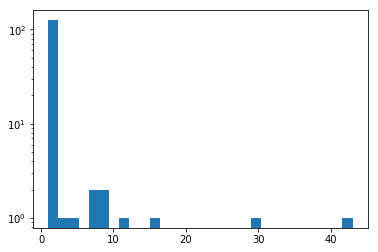

In [20]:
plt.hist(S.degree().values(), bins = 30)
plt.yscale('log')

Lets look at the greater Graph for comparison

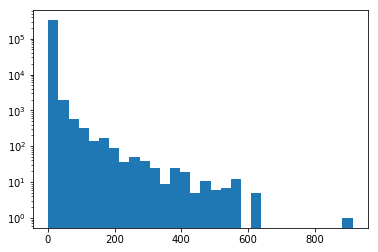

In [21]:
plt.hist(G.degree().values(), bins = 30)
plt.yscale('log')

## Now we divert attention to the total network to identify important nodes

In [46]:
#Function From Social Network Analysis pg 47 modified for Py3
def sorted_map(map):
    ms = sorted(map.items(), key=lambda kv : kv[1], reverse = True)
    return ms
ds=sorted_map(G.degree())

Her we observe a steep drop off in degrees for the top 100 nodes

Text(0.5,1,'Top 100 Nodes by Degree')

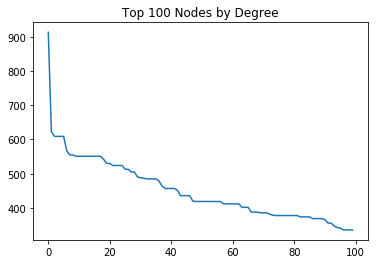

In [119]:
plt.plot([v[1] for v in ds[:100]])
plt.title('Top 100 Nodes by Degree')

Extract the top ten nodes in terms on degrees to build subgraph

In [163]:
gtop = [v[0] for v in ds[:10]]
ds[:10]

[('B007JFMH8M', 913),
 ('B003B3OOPA', 623),
 ('B002QWP89S', 609),
 ('B0026RQTGE', 609),
 ('B002QWHJOU', 609),
 ('B002QWP8H0', 609),
 ('B001EO5Q64', 567),
 ('B000KV61FC', 555),
 ('B000KV7ZGQ', 555),
 ('B0013NUGDE', 551)]

Build a list of nodes using the top ten nodes and their neighbors

In [300]:
gtopmesh = gtop
gtopmeshlc = [gtopmesh.append(k) for v in gtop for k in G.to_undirected().neighbors(v) if k not in gtopmesh]

KeyboardInterrupt: 

In [302]:
print('This subgraph will contain',len(gtopmesh),'nodes')

This subgraph will contain 4668 nodes


In [304]:
T = nx.subgraph(G,gtopmesh)

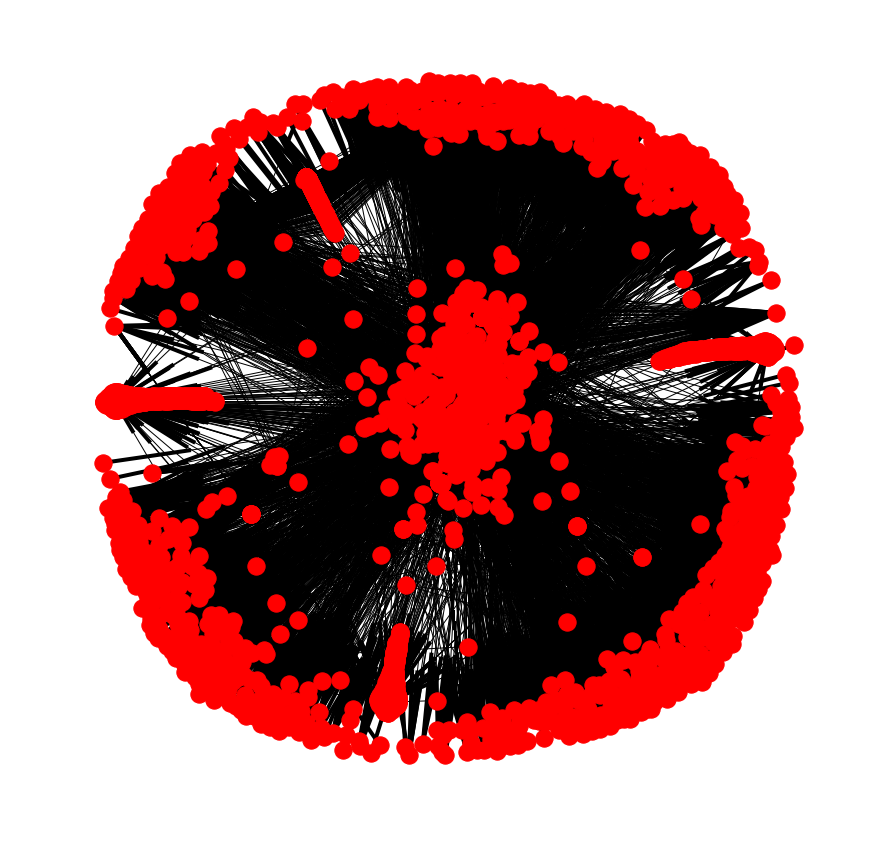

In [305]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(T)

In [306]:
print(nx.info(T))

Name: 
Type: DiGraph
Number of nodes: 4668
Number of edges: 14464
Average in degree:   3.0985
Average out degree:   3.0985


### Conclusion
The above analysis proofed to be a basic but informative anlaysis example.  From a simple graph, we can draw insights on the nature of the dataset.  We learned that the products are the hubs of the network, rather than the reviewers.

In [ ]:
https://youtu.be/WTqrGnnq8iM